# SODA: Bottleneck Diffusion Models for Representation Learning
## Introduction
SODA is a self-supervised diffusion model designed for representation learning. The model uses an encoder to produce a latent representation of a source view. This latent representation is then used to guide the generation of novel views by a diffusion model. The model is trained in a self-supervised manner using a novel view synthesis objective. Abstractly, given a source view, the model is trained to generate novel views of the same object, guided by additional information about the target view.

## Goal of This Project
In the SODA paper, the authors experiment with various tasks to demonstrate the model's capability to learn high-quality representations. These tasks include Linear-Probe Classification, Visual Synthesis, Disentanglement, and Controllability of the latent structure. In this project, I focus on the Visual Synthesis task, specifically Novel View Synthesis for 3D datasets.`

In [ ]:
!pip install -r requirements.txt
!sudo apt-get install p7zip-full

## Database
For this experiment, I used the NMR (Neural 3D Mesh Renderer) dataset, which contains 13 groups of objects. For each object, there are 24 views captured by positioning the camera at a constant distance and elevation, with 24 evenly spaced azimuth angles. The dataset contains roughly one million images (considering all the views for each object). The resolution of each image in the dataset is 64x64.

Here are the classes present in the NMR dataset:

In [1]:
import yaml
from pathlib import Path
from src.datasets import NMR
from visualization import plot_multiple_views

with open(Path('configs/NMR.yaml'), 'r') as file:
    cfg = yaml.full_load(file)
dataset = NMR(**cfg['dataset'])
test_set = dataset.get_test_set().get_target_dataset()
print(dataset.CLASS_IDS_MAP)

Dataset already downloaded!
Dataset already extracted!
{'02691156': 'Airplane', '02958343': 'Car', '04256520': 'Sofa'}


Examples of views for some objects:

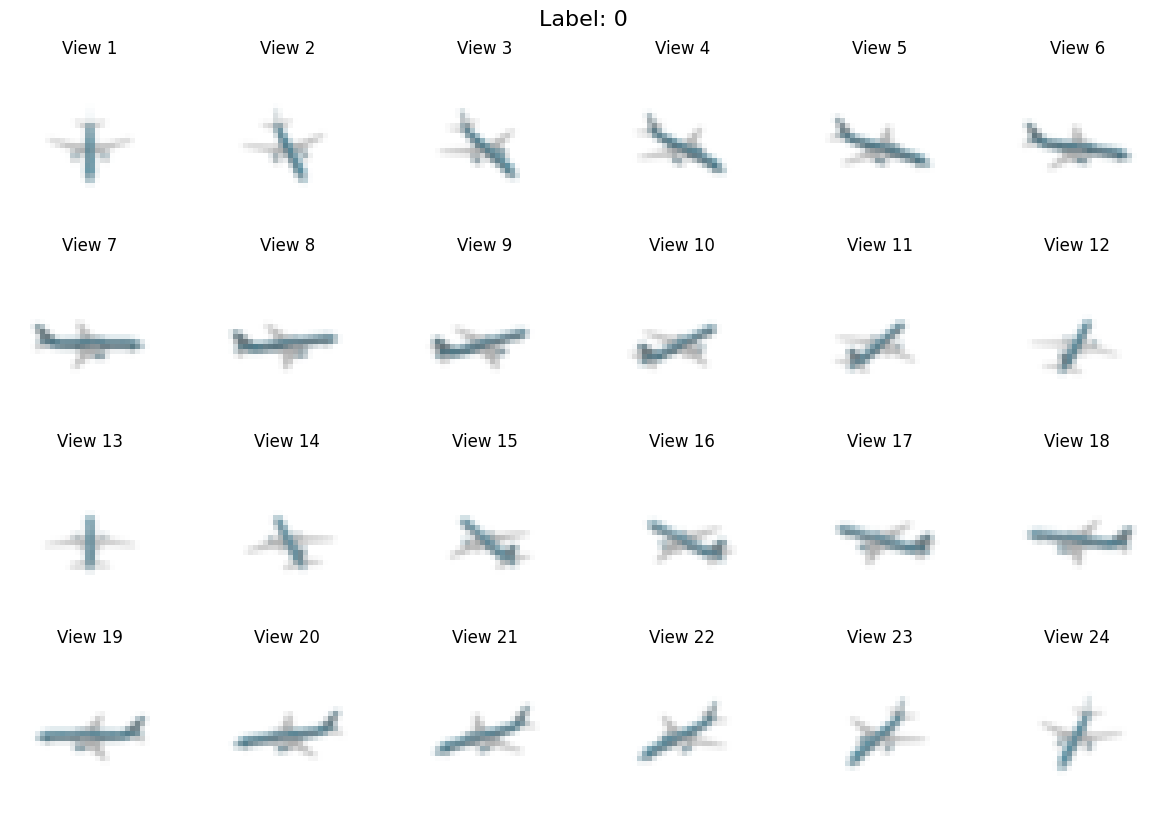

In [2]:
object_plane_views, _, label = test_set.get_all_views(3)
object_plane_views = (object_plane_views.permute(0, 2, 3, 1) + 1) / 2
plot_multiple_views(object_plane_views, label)

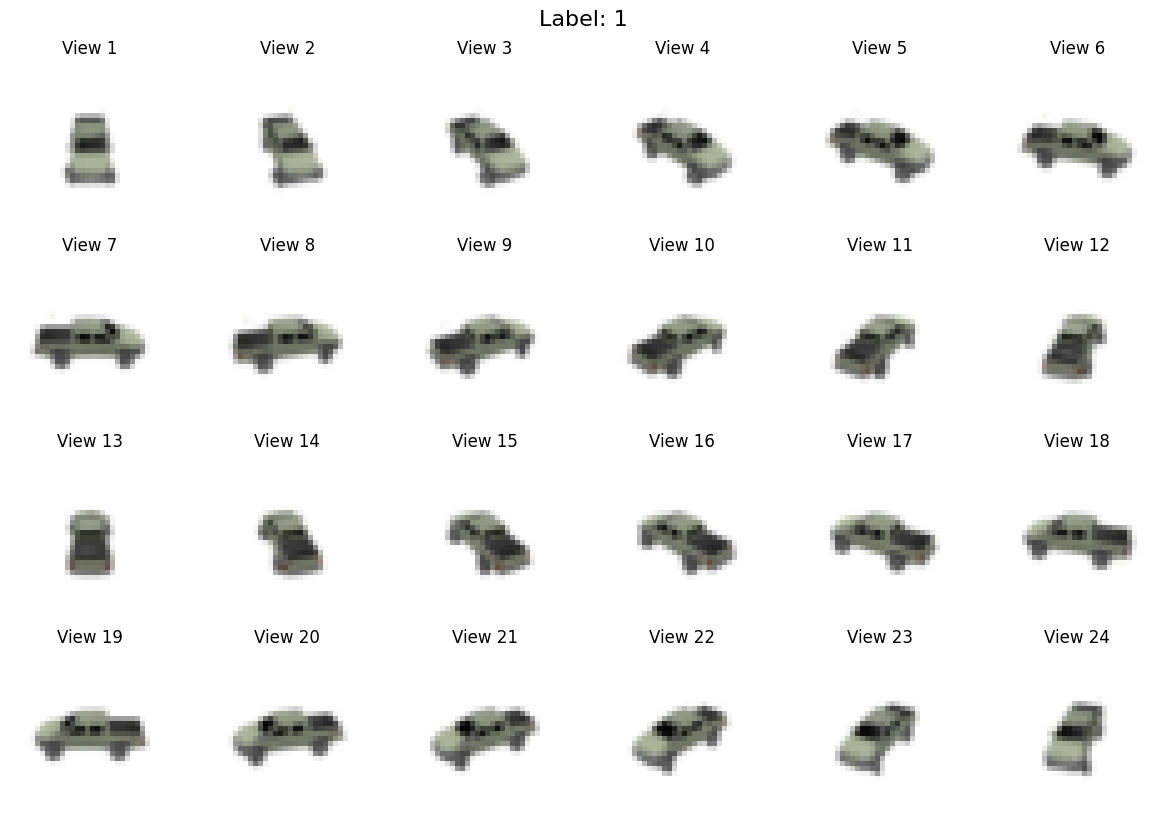

In [3]:
object_car_views, _, label = test_set.get_all_views(2000)
object_car_views = (object_car_views.permute(0, 2, 3, 1) + 1) / 2
plot_multiple_views(object_car_views, label)

In [15]:
from sample import generate_GIF
from IPython.display import display, HTML, Image as IPImage
sample_data_dir = Path('outputs/presentation_files')
sample_data_dir.mkdir(exist_ok=True)
nbs_plane_path = sample_data_dir/Path('nbs_plane.gif')
nbs_car_path = sample_data_dir/Path('nbs_car.gif')
generate_GIF(object_plane_views, nbs_plane_path)
generate_GIF(object_car_views, nbs_car_path)
# gif_html = f'''
# <div style="display: flex; justify-content: center; gap: 20px; margin-top: 20px;">
#     <div>
#         <img src="{nbs_plane_path}" style="width:300px; height:auto;" loop="infinite"/>
#     </div>
#     <div>
#         <img src="{nbs_car_path}" style="width:300px; height:auto;" loop="infinite"/>
#     </div>
# </div>
# '''
gif_html = f'''
<div style="display: flex; justify-content: center; gap: 20px; margin-top: 20px;">
    <div>
        <img src="media/samples/3-real.gif" style="width:300px; height:auto;" loop="infinite"/>
    </div>
    <div>
        <img src="media/samples/2000-real.gif" style="width:300px; height:auto;" loop="infinite"/>
    </div>
</div>
'''
HTML(gif_html)

To make training feasible with my computational resources, I excluded 10 classes from the dataset and used only three classes to train the model. These three classes are `Airplane`, `Car`, and `Sofa`. Hence, the number of objects remaining in the dataset after removing the other classes is:

In [5]:
# airplane_id, car_id, sofa_id = '02691156', '02958343', '04256520'
import json
print(json.dumps(dataset.get_dataset_size_info(), indent=4))

{
    "train": {
        "02691156": 2831,
        "02958343": 5247,
        "04256520": 2221
    },
    "val": {
        "02691156": 405,
        "02958343": 749,
        "04256520": 317
    },
    "test": {
        "02691156": 809,
        "02958343": 1500,
        "04256520": 635
    }
}


Each split has two corresponding datasets: one source dataset and one target dataset. The source dataset is used to provide input data to the encoder model, while the target dataset provides data for the diffusion model. Items in the dataset correspond to each object and all of its 24 views. It is possible to load a different number of views for each object when drawing batches from the dataloader. Additionally, the image transformations for the source (encoder input) and target (denoiser input) datasets differ.

In [6]:
print(dataset.encoder_transformations)
print(dataset.denoizer_transformation)

Compose(
      Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.90754463, 0.90124703, 0.89597464], std=[0.21146126, 0.22668979, 0.24028395], inplace=False)
)
Compose(
      Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      Lambda(<lambda>, types=['object'])
)


In addition to the 24 views corresponding for each object, the NMR dataset provides camera matrix information for each view. This information is used to generate 2D ray-grids for each image, where each ray is the concatenation of the origin vector and direction vector:
$$
r = [o, d]
$$
These ray-grids are later used to provide additional guidance signals for both the encoder and the diffusion model. 

In each batch, we have one source batch and one target batch, with each containing the corresponding views, ray-grids, and labels.


In [7]:
test_loader = dataset.get_test_dataloader()
source_batch, target_batch = next(iter(test_loader))
source_views, source_rays, source_labels = source_batch
target_views, target_rays, target_labels = target_batch
print(source_views.shape, source_rays.shape, source_labels.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32, 32, 32, 6]) torch.Size([32])


## Implementation Details
### Encoder
For the encoder $\mathcal{E}$ model, the authors state that they used `ResNet50 V2` for the NMR dataset. However, I used the smaller version, `ResNet18 V2`, to reduce training costs. In the original paper, the authors mention resizing images to 256x256 before feeding them to the encoder. In this project, I used 64x64 and 32x32 images, so I replaced the first convolution layer of the ResNet (which has a kernel size of 7) with a convolution layer with a kernel size of 3. Furthermore, I removed the first max pooling layer in the network.

Before feeding images to the decoder, I applied NeRF-style sinusoidal positional encoding to transform ray information from Cartesian coordinates to the frequency spectrum. The dimension of the encoded rays depends on the number of frequency bands. I used 30 bands (15 for position and 15 for directions).


In [8]:
import torch
from src.models.blocks import RayEncoder
pose_embedding = RayEncoder(pos_octaves=15, dir_octaves=15)
ray_pos, raydirs = torch.split(source_rays, (3, 3), dim=-1)
encoded_rays = pose_embedding(ray_pos, raydirs)
print(encoded_rays.shape)

torch.Size([32, 180, 32, 32])


After encoding the ray-grids, we concatenate them with the linearly projected source images along the channel dimension and feed them to the encoder.  
The encoder then produces a latent vector $z$, which is used to guide the generation in the denoiser decoder:  
$$
z = \mathcal{E}(\text{concat}[x', c])
$$


In [9]:
from src.models import SodaEncoder
encoder = SodaEncoder(**cfg['encoder'])
z = encoder(source_views, source_rays)
print(z.shape)

torch.Size([32, 256])


### Decoder (Denoising Diffusion Model)
The architecture used for the decoder $\mathcal{D}$ in SODA is a U-Net, similar to the model used in the DDPM paper, with some modifications. In the original paper, the authors state that they used 128x128 images to train the decoder. However, in this project, I experimented with lower-resolution images (64x64 and 32x32). Similar to the encoder, we concatenate the ray-grids with the linearly projected noisy target images and feed them to the denoiser:  
$$
\epsilon_{\theta} = \mathcal{D}(\text{concat}[x, c], z, t, m)
$$  
where $m$ is the mask used to randomly mask $z$.  

The latent vector $z$ guides the denoiser using Classifier-Free Guidance and Adaptive Group Normalization:  
$$
\text{AdaGN}(h, z, t) = z_s (t_s\text{GroupNorm}(h) + t_b) z_b
$$  
where $(t_s, t_b)$ and $(z_s, z_b)$ are linear projections of the time embedding and latent vector, respectively.  

In the paper, the authors mention that for 3D datasets and the NVS task, using cross-attention for conditioning on $z$ can slightly improve performance.  

For time embeddings, the authors used a modified version of sinusoidal positional encoding, where they scale the arguments of $\sin$ and $\cos$ by a factor of $2\pi s$, with $s$ being a scale hyperparameter set to $1e-4$.


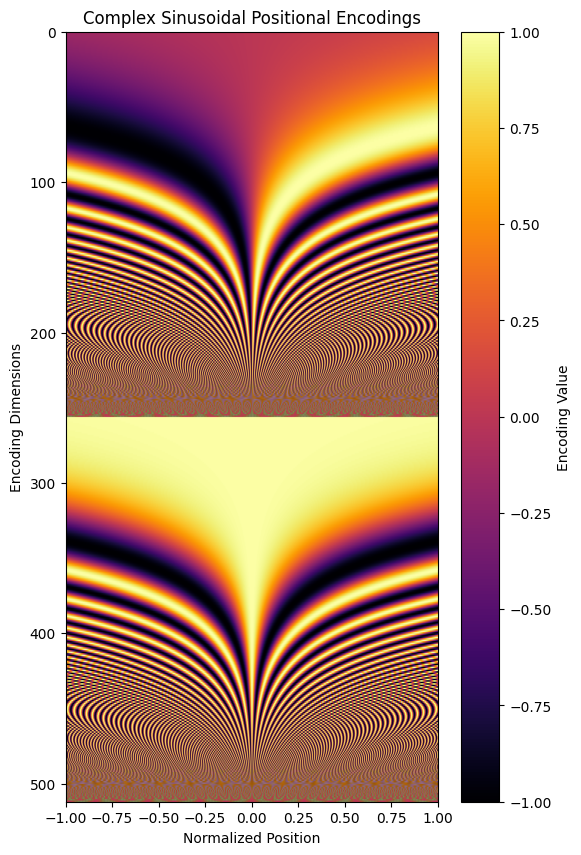

In [10]:

import numpy as np
from visualization import plot_sinusoidal_encoding
from src.models.blocks import ScaledSinusoidalPositionEmbedBlock
scaled_sin_enc = ScaledSinusoidalPositionEmbedBlock(dim=512)
positions = torch.linspace(-1, 1, steps=1000)
encodings = scaled_sin_enc(positions)
plot_sinusoidal_encoding(encodings.squeeze().detach().numpy().T)

For the noise schedule used to perturb input images for the denoiser, the authors propose a novel method called the `Inverted Cosine Schedule`. This schedule prioritizes medium noise levels, which apparently aids in the task of representation learning.

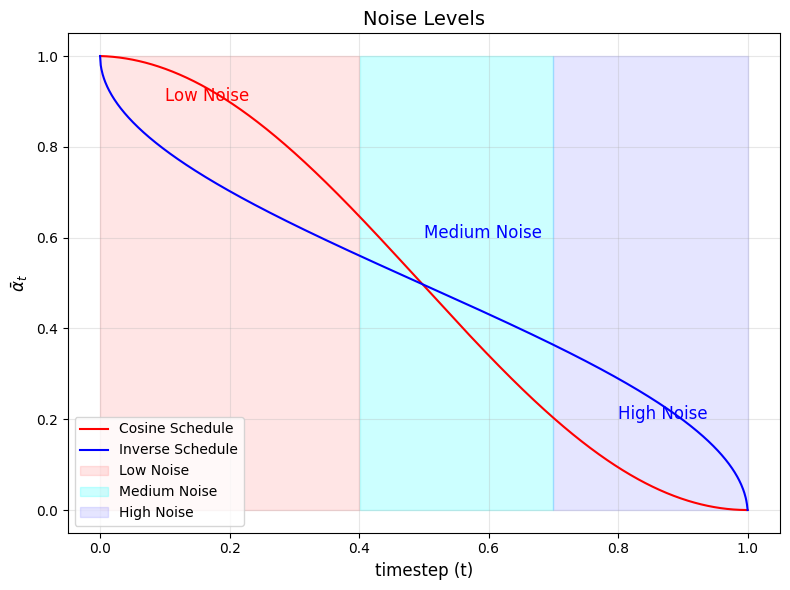

In [11]:
from src.models.noise_schedules import get_schedule
from visualization import plot_noise_schedules
T = 1000
cosine_sche = get_schedule('cosine', T)
inverted_cosine_sche = get_schedule('inverted', T)
plot_noise_schedules(cosine_sche, inverted_cosine_sche, T)

### Joint Model
The encoder $\mathcal{E}$ and decoder $\mathcal{D}$ are trained jointly. At each training step:

1. One source view $x'$ and one target view $x$ are sampled for each object in the batch, along with their corresponding ray-grids $c'$ and $c$ (encoded with NeRF encoding).
2. The encoder generates the latent vector:
   $$
   z = \mathcal{E}(\text{concat}[x', c'])
   $$
3. A timestep $t$ is randomly sampled from a uniform distribution $t \sim \text{Uniform}[0, T]$, normalized to the range $[-1, 1]$, and encoded with sinusoidal encoding.
4. A random mask $m$ is sampled from a Bernoulli distribution with a pre-specified probability.
5. The target view $x$ is perturbed using noise at time step $t$:
   $$
   \epsilon \sim \mathcal{N}(0, \boldsymbol{I})
   $$
   $$
   x_t = \sqrt{\bar{\alpha_t}} \, x_0 + (1 - \bar{\alpha_t}) \, \epsilon
   $$
6. The noisy image $x_t$, its ray-grid $c$, latent vector $z$, time embedding $t$, and the mask $m$ are fed to the decoder:
   $$
   \epsilon_{\theta} = \mathcal{D}(\text{concat}[x, c], z, t, m)
   $$
7. The joint model is trained to minimize the MSE loss:
   $$
   \mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta \|_2^2 \right]
   $$


In [12]:
from src.models import UNet, SODA
denoiser = UNet(**cfg['denoiser'])
soda = SODA(
        encoder=encoder,
        decoder=denoiser,
        **cfg['SODA']
    )

## Training
I trained the model with different hyperparameters on an RTX 4080 GPU. Training with three classes took more than 20 hours for 32x32 images and over 60 hours for 64x64 images.

### Simplifications
The generated samples and evaluation metrics (except for the Linear-Probe task) are far from those depicted in the paper. I believe the reasons are as follows:
1. The authors trained their models on higher resolutions, which require approximately 32 to 64 times more computational time than my experiments.
2. I used a simpler encoder architecture compared to what was described in the paper.
3. I simplified the U-Net to reduce computational costs, which may have resulted in lower-quality samples.
4. I did not implement the cross-attention layer for Classifier-Free Guidance (CFG) using the latent vector and retained the layer modulation approach instead.
5. The number of training steps in my experiments (800–1000 epochs) may have been insufficient.

### Process
The training can be performed by running the `train.py` script as follows:


In [ ]:
!python train.py
# To resume from last saved checkpoint
!python train.py --resume 

After the training is complete, the weights corresponding to the EMA model are saved in the `weights/` directory in the root of the project.

### Training Stats
Below are the graphs showing the evolution of training loss, validation loss, linear probing accuracy, and other metrics during training:

In [20]:
# Load tensorboard logs
%load_ext tensorboard
%tensorboard --logdir 'media/Mosix11-2025-01-08 13:48:39.937665'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6011 (pid 664038), started 0:00:08 ago. (Use '!kill 664038' to kill it.)

In case not tensorboard doesn't load here are some screenshots:

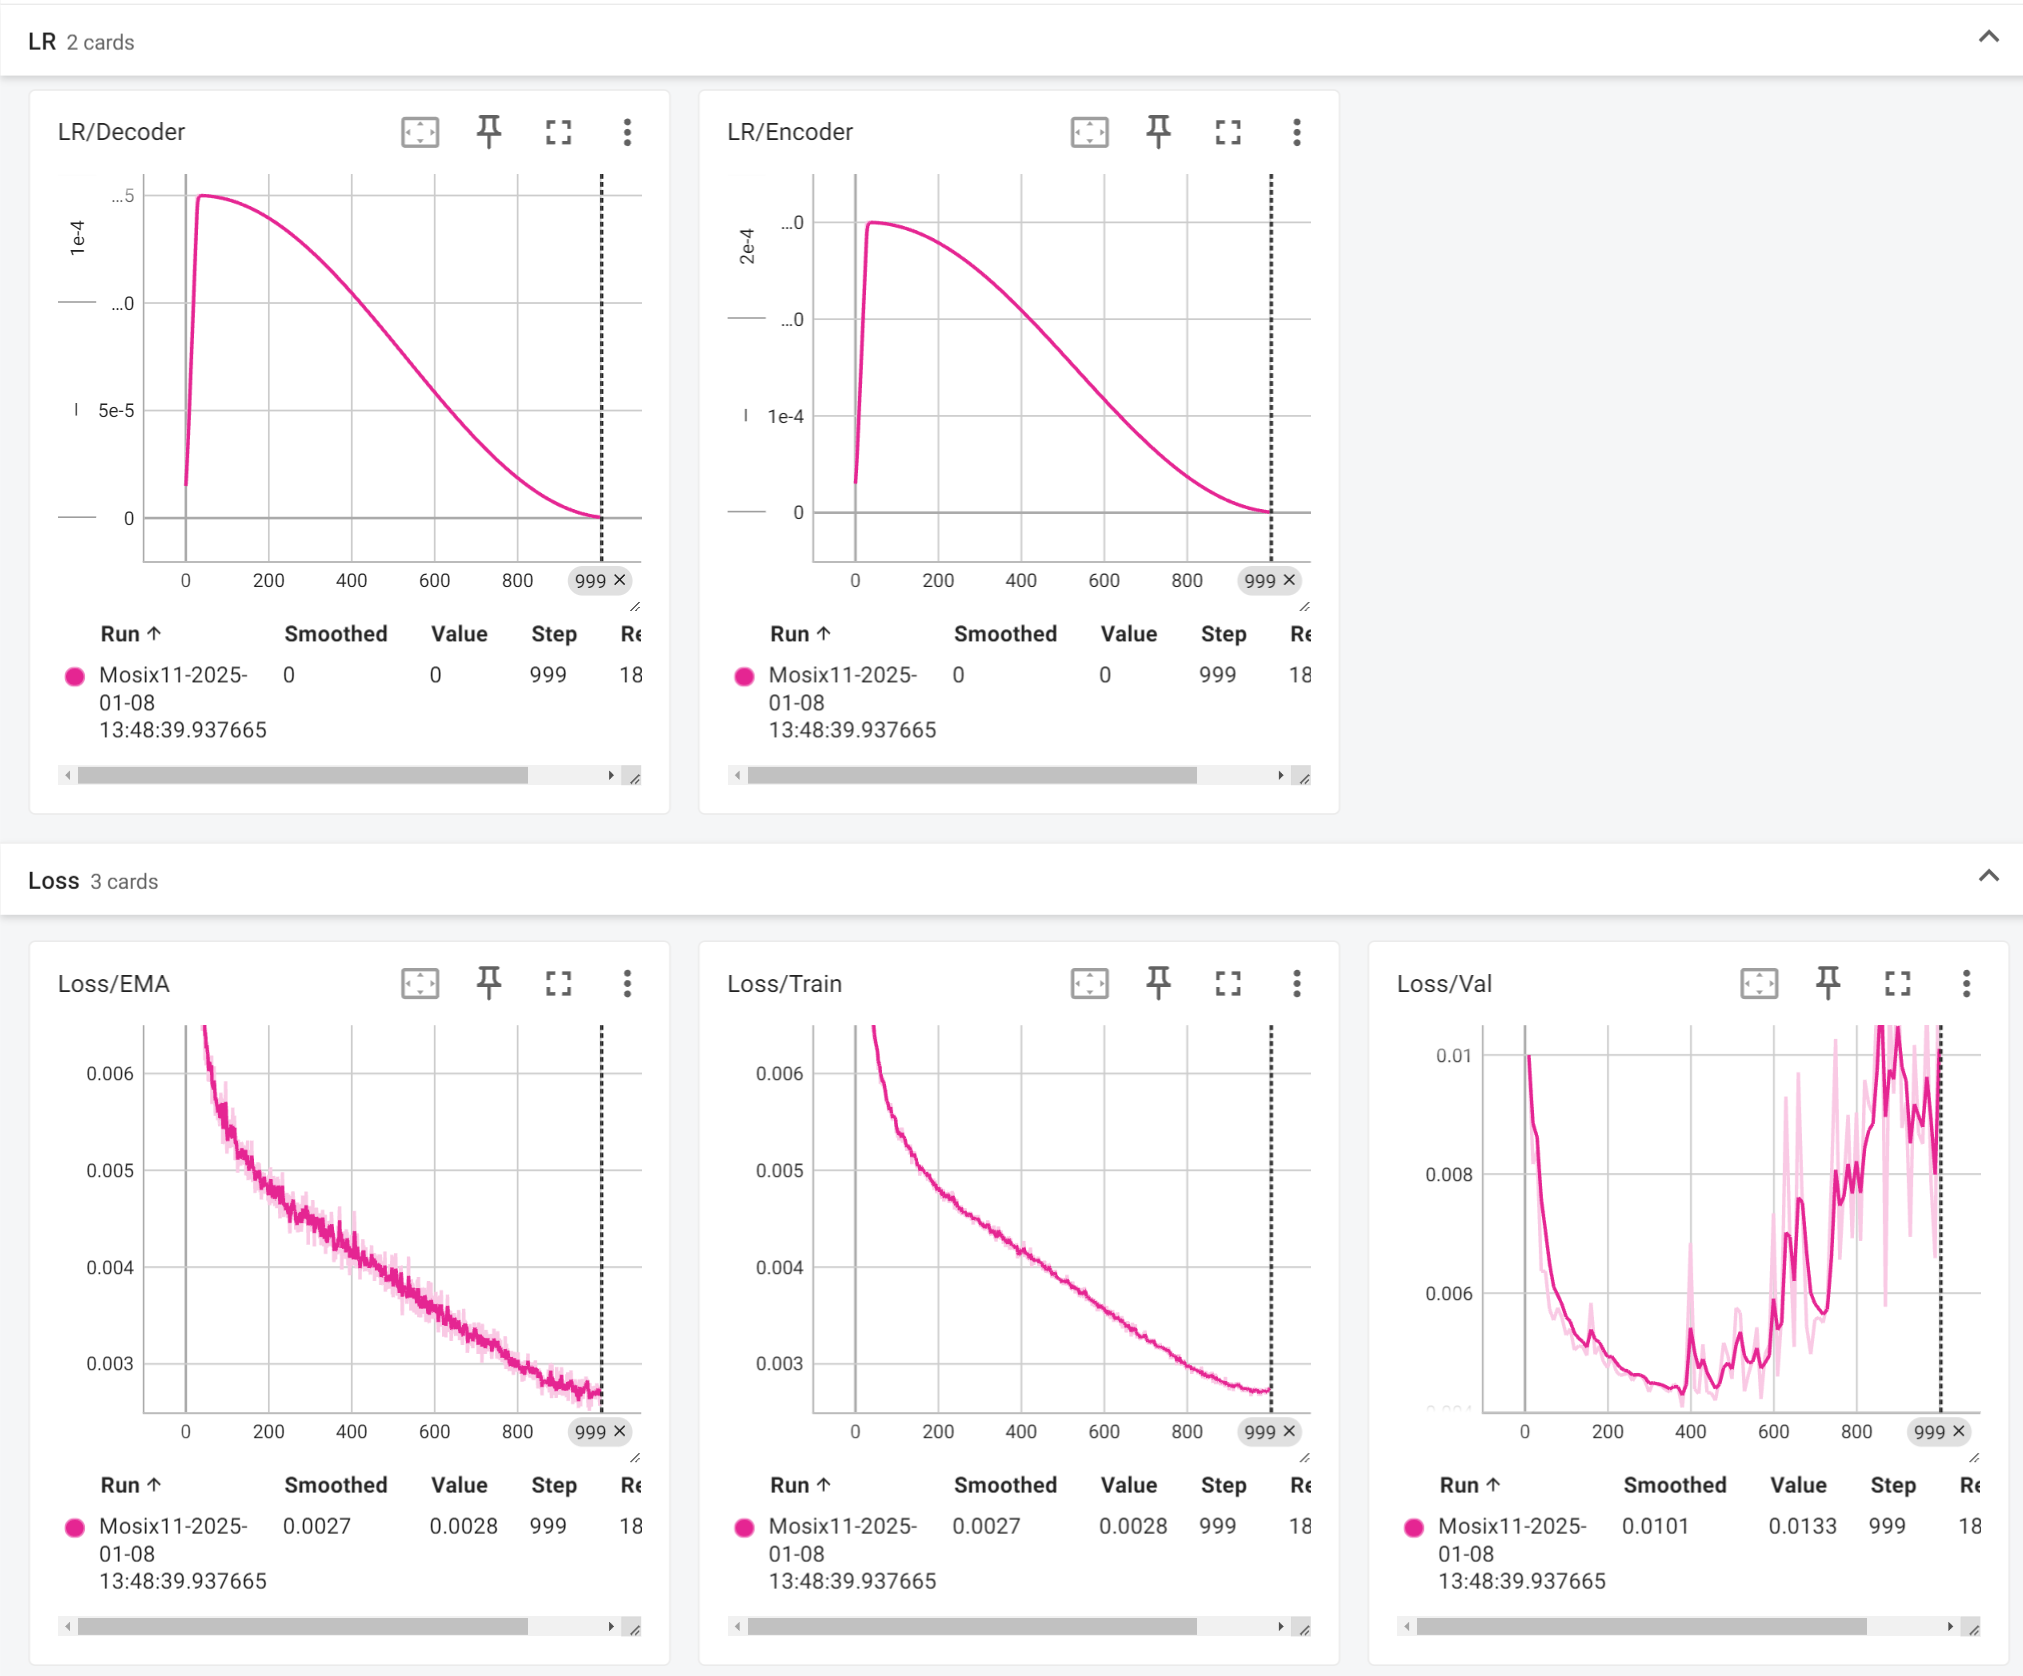

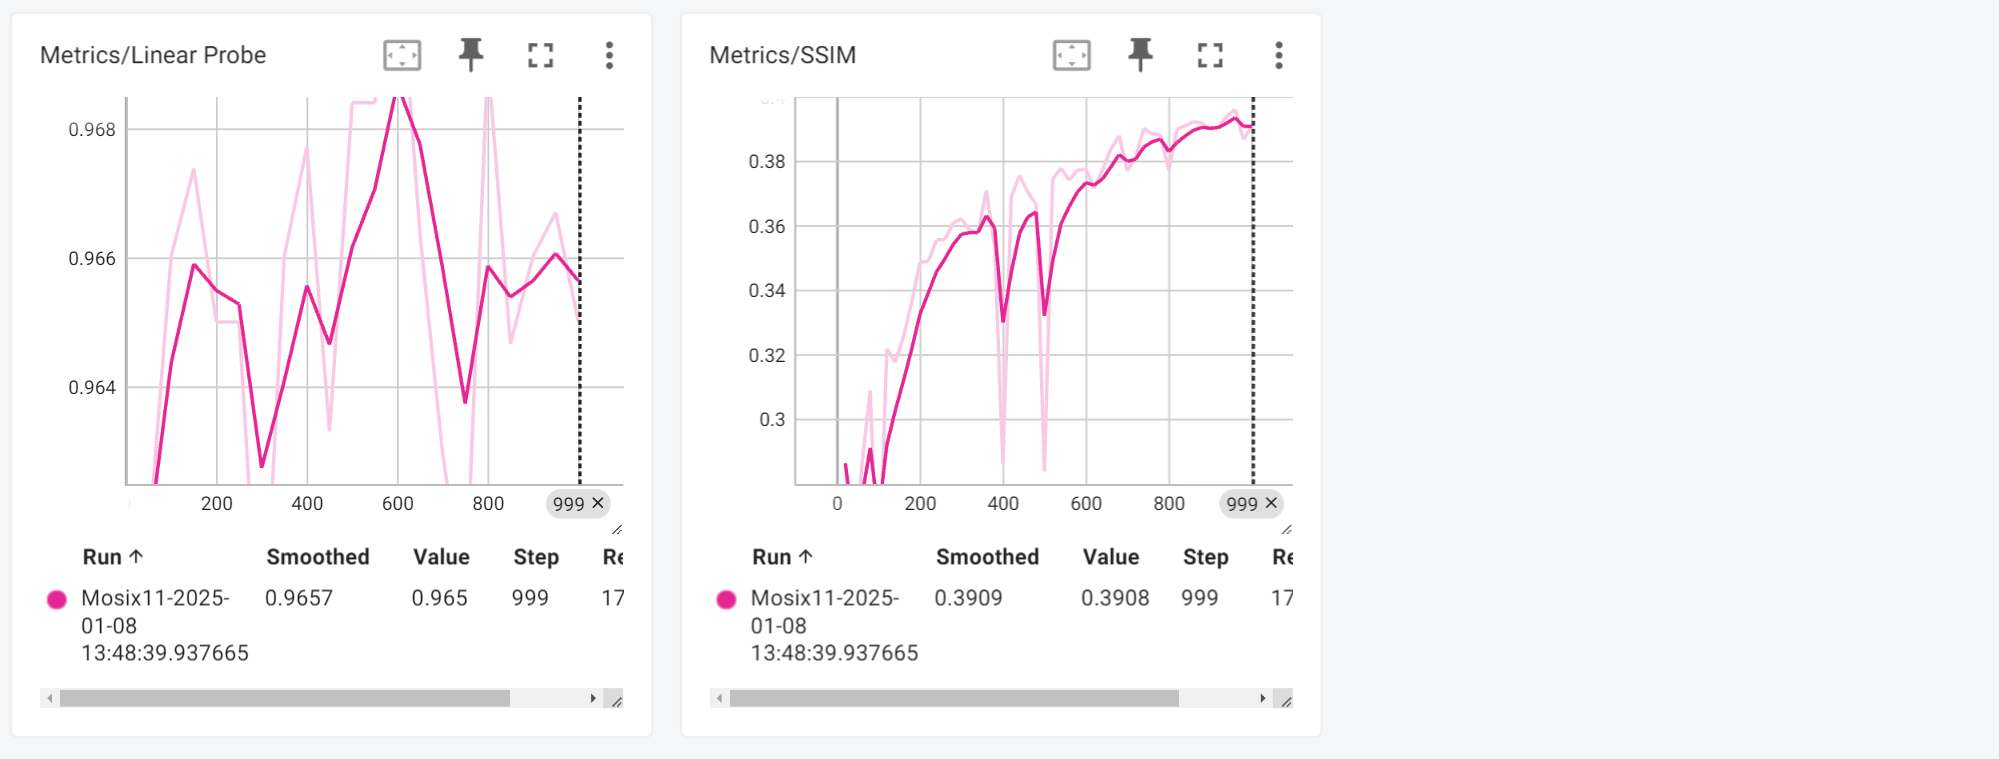

In [16]:
from IPython.display import Image, display
from PIL import Image as PILImage

img1_path = 'media/tensorboard_screenshots/1.png'
img2_path = 'media/tensorboard_screenshots/2.png'

display(PILImage.open(img1_path), PILImage.open(img2_path))

## Sampling
The sampling procedure is performed using the DDIM sampling method (deterministic sampling). Given a random source view of an object, the model is tasked with generating all 24 views corresponding to that object, based on the source view and the ray-grid information of the target views.

We can sample from the model using the test dataset with the following command:

In [ ]:
!python sample.py --objidx 3

Here we can see some examples of Novel View Synthesis using one source view:

In [28]:
def html_template_fill(html: str) -> str:
    return f"""
    <html dir="ltr">
        <head>
            <meta charset="UTF-8">
        </head>
        <body>
            {html}
        </body>
    </html>
    """

In [35]:
from IPython.display import display, HTML

def generate_html(id):
    html_template = html_template_fill(f"""
        <div style="display: flex; flex-direction: column; align-items: center; gap: 20px;">
            <div style="display: flex; justify-content: space-between; align-items: center; width: 100%; max-width: 1000px;">
                <figure style="display: flex; flex-direction: column; text-align: center; width: 40%; margin: 0;">
                    <img src="media/samples/{id}-real.png" style="width: 100%; height: auto;">
                    <figcaption style="text-align: center; margin-top: 10px;">Original views of the object</figcaption>
                </figure>
                <figure style="display: flex; flex-direction: column; text-align: center; width: 10%; margin: 0; display: flex; flex-direction: column; align-items: center; justify-content: center;">
                    <img src="media/samples/{id}-source.png" style="width: 100%; height: auto; object-fit: contain;">
                    <figcaption style="text-align: center; margin-top: 10px;">Source image fed to the encoder</figcaption>
                </figure>
                <figure style="display: flex; flex-direction: column; text-align: center; width: 40%; margin: 0;">
                    <img src="media/samples/{id}-gen.png" style="width: 100%; height: auto;">
                    <figcaption style="text-align: center; margin-top: 10px;">Generated views by the denoiser</figcaption>
                </figure>
            </div>

            <div style="display: flex; justify-content: center; gap: 200px; margin-top: 20px;">
                <figure style="text-align: center; margin: 0;">
                    <img src="media/samples/{id}-real.gif" style="width: 200px; height: auto;">
                    <figcaption style="text-align: center; margin-top: 10px;">Original GIF</figcaption>
                </figure>
                <figure style="text-align: center; margin: 0;">
                    <img src="media/samples/{id}-gen.gif" style="width: 200px; height: auto;">
                    <figcaption style="text-align: center; margin-top: 10px;">Generated GIF</figcaption>
                </figure>
            </div>
        </div>
    """)
    return html_template

HTML(generate_html(1000))


In [36]:
HTML(generate_html(3))

In [32]:
HTML(generate_html(2000))

In [33]:
HTML(generate_html(2502))

In [34]:
HTML(generate_html(40))